# 06 - Effect Heterogeneity


## From ATE to CATE
 
 
## Why Prediction is not the Answer


## CATE with Regression


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import matplotlib

from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

matplotlib.rcParams.update({'font.size': 18})

In [2]:
data = pd.read_csv("./data/daily_restaurant_sales.csv")

data.head()

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales
0,0,2016-01-01,1,4,False,True,False,False,2.88,0,79.0
1,0,2016-01-02,1,5,True,False,False,False,2.64,0,57.0
2,0,2016-01-03,1,6,True,False,False,False,2.08,5,294.0
3,0,2016-01-04,1,0,False,False,False,False,3.37,15,676.5
4,0,2016-01-05,1,1,False,False,False,False,3.79,0,66.0


In [3]:
import statsmodels.formula.api as smf

X = ["C(month)", "C(weekday)", "is_holiday", "competitors_price"]
regr_cate = smf.ols(f"sales ~ discounts*({'+'.join(X)})",
                    data=data).fit()

In [5]:
f"sales ~ discounts*({'+'.join(X)})"

'sales ~ discounts*(C(month)+C(weekday)+is_holiday+competitors_price)'

In [6]:
ols_cate_pred = (
    regr_cate.predict(data.assign(discounts=data["discounts"]+1)) 
    -regr_cate.predict(data)
)

In [7]:
ols_cate_pred

0       53.302535
1       48.652492
2       47.547577
3       43.195858
4       42.108752
          ...    
7674    42.197410
7675    28.919270
7676    38.855831
7677    33.862166
7678    26.322954
Length: 7679, dtype: float64

## Evaluating CATE Predictions


In [15]:
train = data.query("day<'2018-01-01'")
test = data.query("day>='2018-01-01'")

In [16]:
X = ["C(month)", "C(weekday)", "is_holiday", "competitors_price"]
regr_model = smf.ols(f"sales ~ discounts*({'+'.join(X)})",
                     data=train).fit()

cate_pred = (
    regr_model.predict(test.assign(discounts=test["discounts"]+1)) 
    -regr_model.predict(test)
)

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

X = ["month", "weekday", "is_holiday", "competitors_price", "discounts"]
y = "sales"

np.random.seed(1)
ml_model = GradientBoostingRegressor(n_estimators=50).fit(train[X],
                                                          train[y])

ml_pred = ml_model.predict(test[X])

In [18]:
np.random.seed(123)

test_pred = test.assign(
    ml_pred=ml_pred,
    cate_pred=cate_pred,
    rand_m_pred=np.random.uniform(-1, 1, len(test)),
)

In [19]:
test_pred[["rest_id", "day", "sales",
           "ml_pred", "cate_pred", "rand_m_pred"]].head()

,rest_id,day,sales,ml_pred,cate_pred,rand_m_pred
731,0,2018-01-01,251.5,236.312960,41.355802,0.392938
732,0,2018-01-02,541.0,470.218050,44.743887,-0.427721
733,0,2018-01-03,431.0,429.180652,39.783798,-0.546297
734,0,2018-01-04,760.0,769.159322,40.770278,0.102630
735,0,2018-01-05,78.0,83.426070,40.666949,0.438938


## Effect by Model Quantile


In [20]:
from toolz import curry

@curry
def effect(data, y, t):
        return (np.sum((data[t] - data[t].mean())*data[y]) /
                np.sum((data[t] - data[t].mean())**2))

In [21]:
effect(test, "sales", "discounts")

32.16196368039615

In [30]:
test_pred

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales,ml_pred,cate_pred,rand_m_pred
731,0,2018-01-01,1,0,False,True,False,False,4.92,5,251.5,236.312960,41.355802,0.392938
732,0,2018-01-02,1,1,False,False,False,False,3.06,10,541.0,470.218050,44.743887,-0.427721
733,0,2018-01-03,1,2,False,False,False,False,4.61,10,431.0,429.180652,39.783798,-0.546297
734,0,2018-01-04,1,3,False,False,False,False,4.84,20,760.0,769.159322,40.770278,0.102630
735,0,2018-01-05,1,4,False,False,False,False,6.29,0,78.0,83.426070,40.666949,0.438938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7674,6,2018-12-28,12,4,False,False,True,False,6.14,15,771.0,598.981916,42.446960,-0.672354
7675,6,2018-12-29,12,5,True,False,True,False,9.29,5,229.0,236.103487,28.696779,0.581846
7676,6,2018-12-30,12,6,True,False,True,False,5.29,10,458.0,411.551171,38.631153,-0.333955
7677,6,2018-12-31,12,0,False,False,True,False,6.78,10,403.0,390.745578,34.023585,0.506215


In [22]:
def effect_by_quantile(df, pred, y, t, q=10):
    
    # makes quantile partitions
    groups = np.round(pd.IntervalIndex(pd.qcut(df[pred], q=q)).mid, 2) 
    
    return (df
            .assign(**{f"{pred}_quantile": groups})
            .groupby(f"{pred}_quantile")
            # estimate the effect on each quantile
            .apply(effect(y=y, t=t))) 


effect_by_quantile(test_pred, "cate_pred", y="sales", t="discounts")

/var/folders/b2/hpshqfpd1gvchzxhms0ysv7r0000gq/T/ipykernel_73248/3593064801.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(effect(y=y, t=t)))


cate_pred_quantile
17.50    20.494153
23.93    24.782101
26.85    27.494156
28.95    28.833993
30.81    29.604257
32.68    32.216500
34.65    35.889459
36.75    36.846889
39.40    39.125449
47.36    44.272549
dtype: float64

In [41]:
pred = "cate_pred"
y = "sales"
t = "discounts"

In [44]:
groups = np.round(pd.IntervalIndex(pd.qcut(test_pred[pred], q=10)).mid, 2) 
test_pred.assign(**{f"{pred}_quantile": groups})

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales,ml_pred,cate_pred,rand_m_pred,cate_pred_quantile
731,0,2018-01-01,1,0,False,True,False,False,4.92,5,251.5,236.312960,41.355802,0.392938,47.36
732,0,2018-01-02,1,1,False,False,False,False,3.06,10,541.0,470.218050,44.743887,-0.427721,47.36
733,0,2018-01-03,1,2,False,False,False,False,4.61,10,431.0,429.180652,39.783798,-0.546297,39.40
734,0,2018-01-04,1,3,False,False,False,False,4.84,20,760.0,769.159322,40.770278,0.102630,39.40
735,0,2018-01-05,1,4,False,False,False,False,6.29,0,78.0,83.426070,40.666949,0.438938,39.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7674,6,2018-12-28,12,4,False,False,True,False,6.14,15,771.0,598.981916,42.446960,-0.672354,47.36
7675,6,2018-12-29,12,5,True,False,True,False,9.29,5,229.0,236.103487,28.696779,0.581846,28.95
7676,6,2018-12-30,12,6,True,False,True,False,5.29,10,458.0,411.551171,38.631153,-0.333955,39.40
7677,6,2018-12-31,12,0,False,False,True,False,6.78,10,403.0,390.745578,34.023585,0.506215,34.65


In [31]:
 
test_pred.assign(**{f"cate_pred_quantile": groups}).groupby(f"cate_pred_quantile")

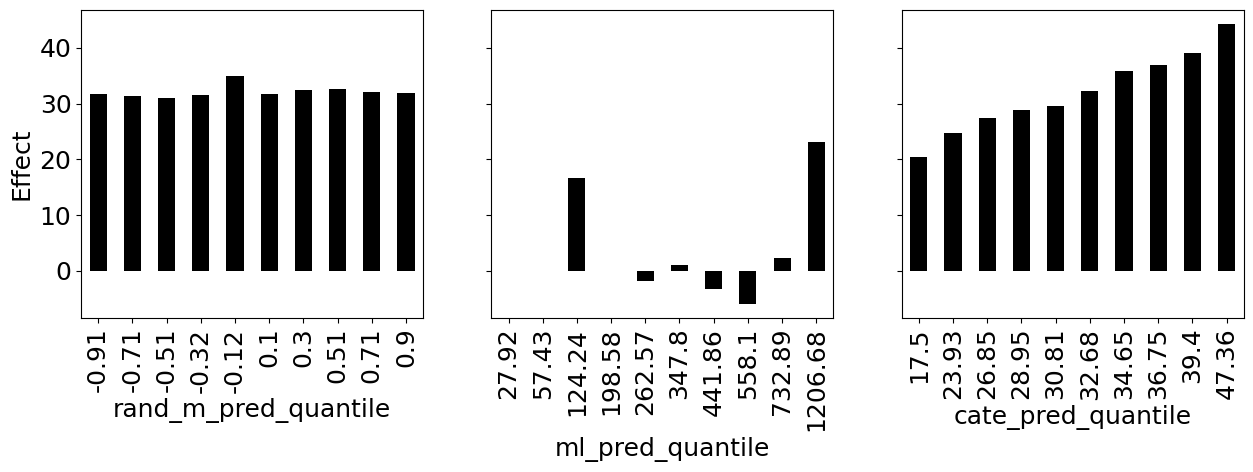

In [28]:
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 4))
for m, ax in zip(["rand_m_pred", "ml_pred", "cate_pred"], axs):
    effect_by_quantile(test_pred, m, "sales", "discounts").plot.bar(ax=ax)
    ax.set_ylabel("Effect")


## Cumulative Effect


In [45]:
np.set_printoptions(linewidth=80, threshold=10)

In [59]:
test_pred.sort_values("cate_pred", ascending=False).reset_index(drop=True)

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales,ml_pred,cate_pred,rand_m_pred
0,3,2018-01-26,1,4,False,False,False,False,2.26,0,50.0,72.207874,53.765862,0.167768
1,0,2018-01-19,1,4,False,False,False,False,3.23,0,62.0,75.155394,50.613022,0.063103
2,0,2018-01-13,1,5,True,False,False,False,2.17,10,558.0,487.197894,50.546816,-0.122856
3,4,2019-01-01,1,1,False,True,False,False,2.22,10,667.0,484.606612,50.053205,0.924547
4,0,2018-01-18,1,3,False,False,False,False,2.07,10,539.0,481.956487,49.773749,-0.649096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2557,2,2018-05-20,5,6,True,False,False,False,9.39,0,45.0,32.766862,13.374585,0.188934
2558,2,2018-06-26,6,1,False,False,False,False,9.26,15,283.5,368.458071,13.307462,0.336003
2559,2,2018-05-21,5,0,False,False,False,False,9.49,0,29.0,11.294837,13.285004,-0.043168
2560,2,2018-05-27,5,6,True,False,False,False,9.44,0,49.0,32.766862,13.212068,-0.385491


In [46]:
def cumulative_effect_curve(dataset, prediction, y, t,
                            ascending=False, steps=100):
    size = len(dataset)
    ordered_df = (dataset
                  .sort_values(prediction, ascending=ascending)
                  .reset_index(drop=True))
    
    steps = np.linspace(size/steps, size, steps).round(0)
    
    return np.array([effect(ordered_df.query(f"index<={row}"), t=t, y=y)
                     for row in steps])

cumulative_effect_curve(test_pred, "cate_pred", "sales", "discounts")

array([49.65116279, 49.37712454, 46.20360341, ..., 32.46981935, 32.33428884,
       32.16196368])

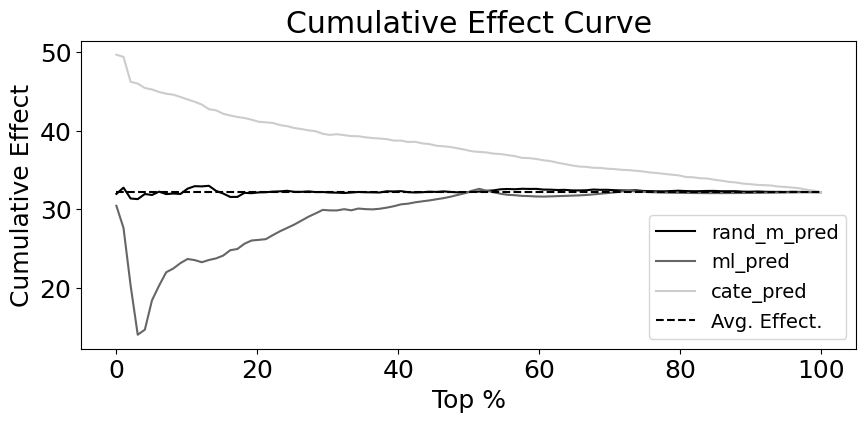

In [47]:
plt.figure(figsize=(10,4))

for m in ["rand_m_pred", "ml_pred", "cate_pred"]:
    cumu_effect = cumulative_effect_curve(test_pred, m, "sales", "discounts", steps=100)
    x = np.array(range(len(cumu_effect)))
    plt.plot(100*(x/x.max()), cumu_effect, label=m)

plt.hlines(effect(test_pred, "sales", "discounts"), 0, 100, linestyles="--", color="black", label="Avg. Effect.")
plt.xlabel("Top %")
plt.ylabel("Cumulative Effect")
plt.title("Cumulative Effect Curve")
plt.legend(fontsize=14)


## Cumulative Gain


In [17]:
def cumulative_gain_curve(df, prediction, y, t,
                          ascending=False, normalize=False, steps=100):
    
    effect_fn = effect(t=t, y=y)
    normalizer = effect_fn(df) if normalize else 0
    
    size = len(df)
    ordered_df = (df
                  .sort_values(prediction, ascending=ascending)
                  .reset_index(drop=True))
    
    steps = np.linspace(size/steps, size, steps).round(0)
    effects = [(effect_fn(ordered_df.query(f"index<={row}"))
                -normalizer)*(row/size) 
               for row in steps]

    return np.array([0] + effects)


cumulative_gain_curve(test_pred, "cate_pred", "sales", "discounts")

array([ 0.        ,  0.50387597,  0.982917  , ..., 31.82346463, 32.00615008,
       32.16196368])

Text(0.5, 1.0, 'Cumulative Gain Curve (Normalized)')

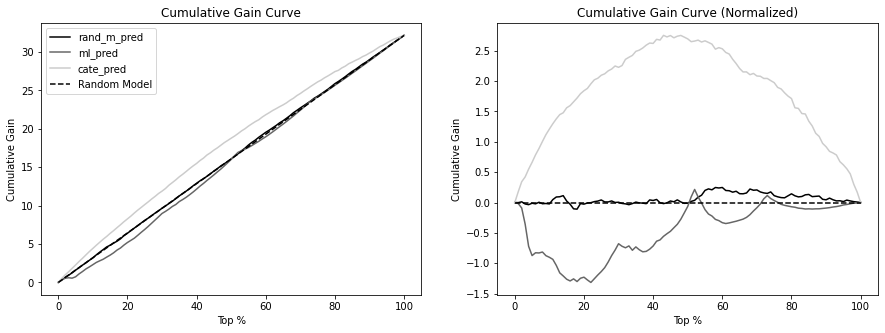

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

for m in ["rand_m_pred", "ml_pred", "cate_pred"]:
    cumu_gain = cumulative_gain_curve(test_pred, m, "sales", "discounts")
    x = np.array(range(len(cumu_gain)))
    ax1.plot(100*(x/x.max()), cumu_gain, label=m)
    
ax1.plot([0, 100], [0, effect(test_pred, "sales", "discounts")], linestyle="--", label="Random Model", color="black")

ax1.set_xlabel("Top %")
ax1.set_ylabel("Cumulative Gain")
ax1.set_title("Cumulative Gain Curve")
ax1.legend()


for m in ["rand_m_pred", "ml_pred", "cate_pred"]:
    cumu_gain = cumulative_gain_curve(test_pred, m, "sales", "discounts", normalize=True)
    x = np.array(range(len(cumu_gain)))
    ax2.plot(100*(x/x.max()), cumu_gain, label=m)
    
ax2.hlines(0, 0, 100, linestyle="--", label="Random Model", color="black")

ax2.set_xlabel("Top %")
ax2.set_ylabel("Cumulative Gain")
ax2.set_title("Cumulative Gain Curve (Normalized)")



In [19]:
for m in ["rand_m_pred", "ml_pred", "cate_pred"]:
    gain = cumulative_gain_curve(test_pred, m,
                                 "sales", "discounts", normalize=True)
    print(f"AUC for {m}:", sum(gain))

AUC for rand_m_pred: 6.0745233598544495
AUC for ml_pred: -45.44063124684
AUC for cate_pred: 181.74573239200615


## Target Transformation

In [61]:
X = ["C(month)", "C(weekday)", "is_holiday", "competitors_price"]

y_res = smf.ols(f"sales ~ {'+'.join(X)}", data=test).fit().resid
t_res = smf.ols(f"discounts ~ {'+'.join(X)}", data=test).fit().resid

tau_hat = y_res/t_res

In [62]:
tau_hat

731       39.831071
732     1290.290268
733      245.624378
734       30.958640
735       36.785470
           ...     
7674      55.569635
7675      30.320101
7676      41.275737
7677       1.179105
7678      18.433106
Length: 2562, dtype: float64

In [63]:
from sklearn.metrics import mean_squared_error

for m in ["rand_m_pred", "ml_pred", "cate_pred"]:
    wmse = mean_squared_error(tau_hat, test_pred[m],
                              sample_weight=t_res**2)
    print(f"MSE for {m}:", wmse)

MSE for rand_m_pred: 1115.803515760459
MSE for ml_pred: 576256.7425385381
MSE for cate_pred: 42.90447405550264


## When Prediction Models are Good for Effect Ordering
 
### Marginal Decreasing Returns


Text(0.5, 0, 'T')

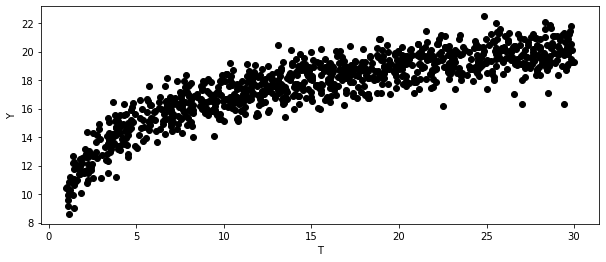

In [22]:
np.random.seed(123)

n = 1000
t = np.random.uniform(1, 30, size=n)
y = np.random.normal(10+3*np.log(t), size=n)

plt.figure(figsize=(10,4))
plt.scatter(t, y)
plt.ylabel("Y")
plt.xlabel("T")



### Binary Outcomes


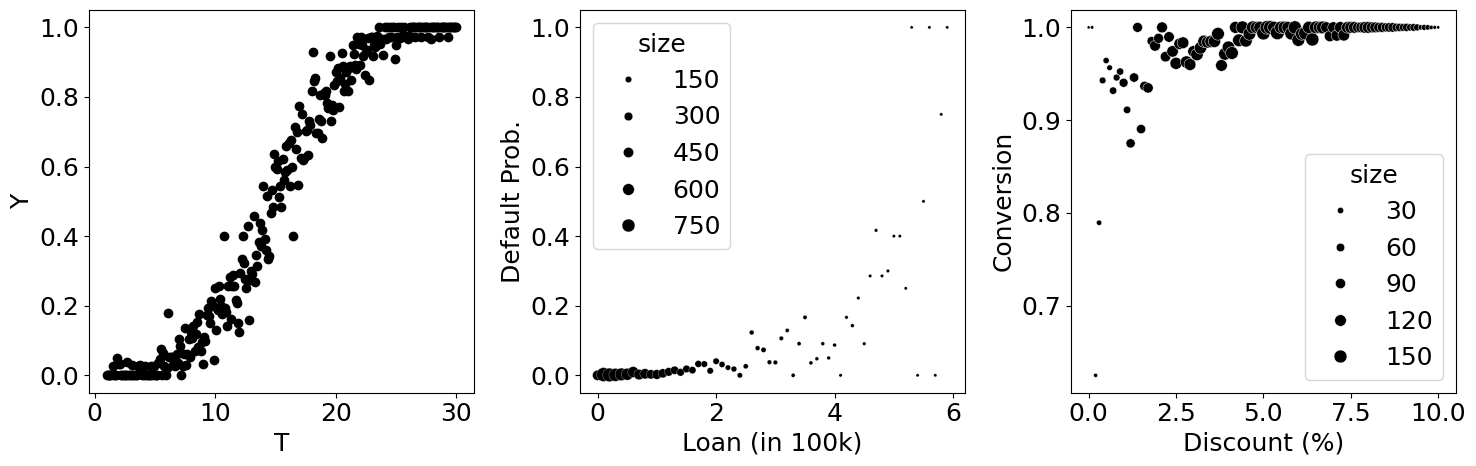

In [64]:
np.random.seed(123)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

n = 10000
t = np.random.uniform(1, 30, size=n).round(1)
y = (np.random.normal(t, 5, size=n) > 15).astype(int)

df_sim = pd.DataFrame(dict(t=t, y=y)).groupby("t")["y"].mean().reset_index()
df_sim

ax1.scatter(df_sim["t"], df_sim["y"])
ax1.set_ylabel("Y")
ax1.set_xlabel("T")


n = 10000
t = np.random.exponential(1, n).round(1).clip(0, 8)
y = (np.random.normal(t, 2, size=n) > 6).astype(int)

df_sim = (pd.DataFrame(dict(t=t, y=y, size=1))
          .query("t<6")
          .groupby("t")
          .agg({"y":"mean", "size":"sum"})
          .reset_index())

sns.scatterplot(data=df_sim, y="y", x="t", size="size", ax=ax2, sizes=(5,100))
ax2.set_ylabel("Default Prob.")
ax2.set_xlabel("Loan (in 100k)")


n = 10000
t = np.random.beta(2, 2, n).round(2)*10
y = (np.random.normal(5+t, 4, size=n) > 0).astype(int)

df_sim = (pd.DataFrame(dict(t=t, y=y, size=1))
          .groupby("t")
          .agg({"y":"mean", "size":"sum"})
          .reset_index())

sns.scatterplot(data=df_sim, y="y", x="t", size="size", ax=ax3, sizes=(5,100))
ax3.set_ylabel("Conversion")
ax3.set_xlabel("Discount (%)")
plt.tight_layout()



## CATE for Decision Making


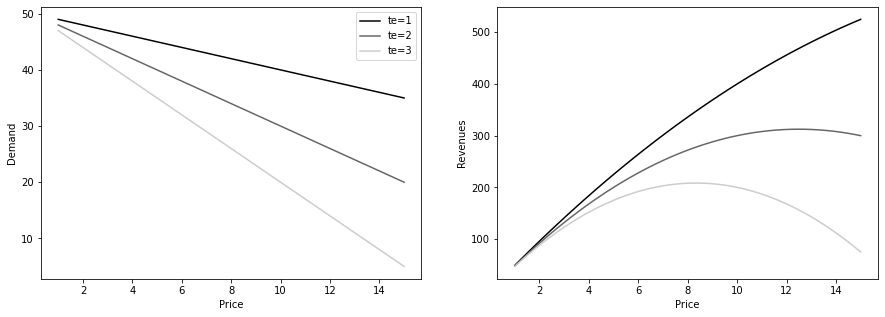

In [24]:
def demand(price, tau):
    return 50-tau*price

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

prices = np.linspace(1, 15)

for i, tau in enumerate([1, 2, 3]):
    q = demand(prices, tau)
    ax1.plot(prices, q, color=f"C{i}", label=f"te={tau}")
    ax2.plot(prices, q*prices, color=f"C{i}", label=f"te={tau}")

ax1.set_ylabel("Demand")
ax1.set_xlabel("Price")

ax2.set_ylabel("Revenues")
ax2.set_xlabel("Price")

ax1.legend()


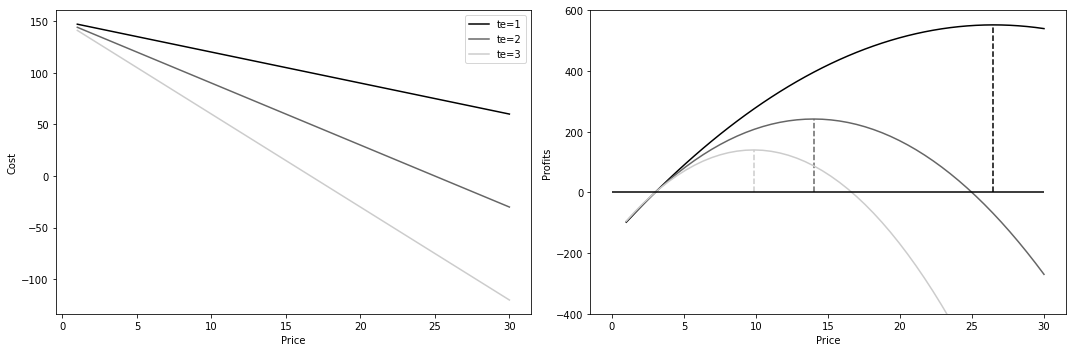

In [25]:
def cost(q):
    return q*3

def profit(price, tau):
    q = demand(price, tau)
    return q*price - cost(q)

prices = np.linspace(1, 30)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

for i, tau in enumerate([1, 2, 3]):
    profits = profit(prices, tau)
    
    max_price = prices[np.argmax(profits)]
    
    ax1.plot(prices, cost(demand(prices, tau)), label=f"te={tau}")
    
    ax2.plot(prices, profits, color=f"C{i}", label=f"te={tau}")
    ax2.vlines(max_price, 0, max(profits), color=f"C{i}", linestyle="--")
    ax2.set_ylim(-400, 600)
    

ax2.hlines(0, 0, max(prices), color="black")
# ax2.legend()
ax2.set_ylabel("Profits")
ax2.set_xlabel("Price");

ax1.legend()
ax1.set_ylabel("Cost")
ax1.set_xlabel("Price")

plt.tight_layout()


## Key Ideas
